楽曲の歌詞をもとに8種の感情を予測するコードです。ここでは回帰によって予測を行っています。分類を行った時に感情が全て0のパターンが発生したので連続的に見たほうが良いと考えたからです。今回の訓練はファインチューニングを用いました。なぜなら、すでに大量の文章が学習されているモデルを使った方が効率よく高い精度を出せると考えたからです。ファインチューニングの評価は以下の通りです。回帰モデルの場合、単純なBERTモデルをhuggingfaceのライブラリを用いた学習で最も良い精度が出ました。今後の施策としては多くの言語の歌詞も分析できるよう、すべての言語を英訳して、googleのgo emotionという28感情のbool値が載ったデータセットを用いて多値分類で感情分析をすることを考えています。なぜなら、今回の成果物で感情の大きさを考慮に入れたことでデータの偏りが生じてしまい、生成するにしてもベクトルが似てしまう可能性が否定できないからです。その代わりに感情を細分化することで十分精密な感情分類は行えると考えます。

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! pip install git+https://github.com/huggingface/transformers
! pip install git+https://github.com/huggingface/accelerate
! pip install datasets
! pip install fugashi ipadic
! pip install unidic-lite

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-rh9vq2jn
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-rh9vq2jn
  Resolved https://github.com/huggingface/transformers to commit 9895f7df81aaf21b4fcc3a70054d3ac3d5894879
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.48.0.dev0-py3-none-any.whl size=10291263 sha256=47ffb467f885693cfb1d6e77806f8ea8873380a46a041224373e0b324bbe4854
  Stored in directory: /tmp/pip-ephem-wheel-cache-p4ijs86r/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
  Cloning https://github.com/huggingfac

In [ ]:
import pandas as pd
emotions = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
emotion_columns = ['Sentence'] + ['Avg. Readers_' + emotion for emotion in emotions]
%cd '/content/drive/MyDrive/成果物3/'
df_wrime_aug = pd.read_csv('wrime_sqlSimCSE_2_filtered.csv')
df_wrime = pd.read_csv('words_filtered_wrime-ver1_2.csv')
df_wrime = pd.concat([df_wrime[emotion_columns], df_wrime_aug[emotion_columns]], ignore_index=True, axis=0)
df_wrime = df_wrime.dropna(subset=['Sentence']) # 'Sentence' 列にNaNが含まれている行を削除

# 各感情の値を一つのリストに変換し、新しい列 'emotions' としてデータフレームに追加
df_wrime['readers_emotion_intensities'] = df_wrime[emotion_columns[1:]].values.tolist()
df_wrime = df_wrime.drop(columns=emotion_columns[1:], axis=1)
df_wrime = df_wrime[df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)]
df_wrime.head()

/content/drive/MyDrive/成果物3


,Sentence,readers_emotion_intensities
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに...,"[0, 2, 0, 0, 0, 0, 0, 0]"
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな?と立ち止まる帰り道。チャリなし生活も悪...,"[1, 0, 0, 2, 0, 0, 0, 0]"
6,やばい。おもろいな?思ってみてみた'シャレードがいっぱい'。よすぎるやん。,"[2, 0, 0, 0, 0, 0, 0, 0]"
7,おなかすいた...夜ご飯仲間募集。,"[0, 0, 2, 0, 0, 0, 0, 0]"
9,最近アップにしていたので気づかなかったけど、ちゃんとブローしたらモテキ小宮山夏樹'後期'に似...,"[1, 0, 2, 0, 0, 0, 0, 0]"


In [ ]:
import numpy as np
import torch
import unidic_lite
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

%cd '/content/drive/MyDrive/成果物3/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# データセットの分割
df_train, df_val = train_test_split(df_wrime, test_size=0.4, random_state=42)
df_dev, df_test = train_test_split(df_val, test_size=0.5, random_state=42)

# 1. Transformers用のデータセット形式に変換
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
dev_dataset = Dataset.from_pandas(df_dev[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])

# 特徴量の抽出
def tokenize_function(batch):
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length', max_length=256, return_tensors='pt')
    tokenized_batch['labels'] = batch['readers_emotion_intensities']
    tokenized_batch['labels'] = torch.tensor(tokenized_batch['labels']).float()
    return tokenized_batch


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions_flattened = np.array(predictions).flatten()
    labels_flattened = np.array(labels).flatten()
    mae = mean_absolute_error(labels_flattened, predictions_flattened)
    r2 = r2_score(labels_flattened, predictions_flattened)
    return {"mae": mae, "r2": r2}


/content/drive/MyDrive/成果物3


In [ ]:
# 繰り返し処理でモデルを読み込むとメモリオーバーか配列がパディングできていない問題が起こる
%cd '/content/drive/MyDrive/成果物3/'
checkpoint = 'tohoku-nlp/bert-base-japanese-v3' # 'tohoku-nlp/bert-base-japanese-v3'
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=8, problem_type="regression")

/content/drive/MyDrive/成果物3


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tohoku-nlp/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('tohoku-nlp/bert-base-japanese-v3')
train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
dev_tokenized_dataset = dev_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/447M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

Parameter 'function'=<function tokenize_function at 0x7fb3a7b404c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/19179 [00:00<?, ? examples/s]

Map:   0%|          | 0/6393 [00:00<?, ? examples/s]

Map:   0%|          | 0/6394 [00:00<?, ? examples/s]

In [ ]:
# 訓練時の設定
training_args = TrainingArguments(
    output_dir="regression_bert+_1_6",
    per_device_train_batch_size=40,
    num_train_epochs=7,
    learning_rate=2e-5,
    warmup_steps=128,
    weight_decay=0.001,
    save_strategy="epoch",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    lr_scheduler_type="linear"
    )

# Trainerを生成
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=dev_tokenized_dataset,
    compute_metrics=compute_metrics,
)

#繰り返し処理を行うと精度が悪くなる上、予測の際にCUDAでエラーが起きる
trainer.train()
trainer.save_model()
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1573: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 37


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Mae,R2
1,0.398900,0.246721,0.315417,0.632332
2,0.219800,0.198195,0.270878,0.704647
3,0.164300,0.179878,0.248850,0.731944
4,0.131300,0.170306,0.237405,0.746207
5,0.109200,0.160843,0.225508,0.760309
6,0.096100,0.157691,0.221532,0.765006
7,0.087800,0.156538,0.219408,0.766725


In [ ]:
eval = trainer.evaluate(test_tokenized_dataset)
print(eval)

{'eval_loss': 0.15696026384830475, 'eval_mae': 0.2201181799173355, 'eval_r2': 0.765510082244873, 'eval_runtime': 90.7176, 'eval_samples_per_second': 70.482, 'eval_steps_per_second': 8.819, 'epoch': 7.0}


In [ ]:
# 何度かパラメータを試し、最高のものができてから。配列化はアンサンブル予測の際にロードしてから。
prediction = trainer.predict(test_tokenized_dataset)
prediction = prediction.predictions
prediction = np.array(prediction).reshape(-1, 8)
df = pd.DataFrame(prediction)
df.to_csv('regression_bert+_1_6/testdata.csv', index=False)

In [ ]:
#歌詞のそれぞれの予測
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from tqdm import tqdm

models = AutoModelForSequenceClassification.from_pretrained("regression_bert+_1_6", num_labels=8, problem_type="regression")
tokenizers = AutoTokenizer.from_pretrained("tohoku-nlp/bert-base-japanese-v3")

def predict_tokenize_function(batch):
    tokenized_batch = tokenizer(batch['歌い出し'], truncation=True, padding='max_length', max_length=512, return_tensors='pt')
    return tokenized_batch

%cd '/content/drive/MyDrive/成果物3/'
df_new = pd.read_csv('artist_combined.csv', encoding='shift_jis')
df_new['歌い出し'] = df_new['歌い出し'].str.replace('\\U3000', '')

/content/drive/MyDrive/成果物3


In [ ]:
from datasets import Dataset
from transformers import TrainingArguments, Trainer
model.eval()
df_pre = Dataset.from_pandas(df_new[['歌い出し']].copy())
predict_tokenized_dataset = df_pre.map(predict_tokenize_function, batched=True)
# 訓練時の設定
training_args = TrainingArguments(
    output_dir="regression_bert+_1_6-3",
    per_device_train_batch_size=40,
    num_train_epochs=3, #4以内
    learning_rate=2e-5,
    warmup_steps=110,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    lr_scheduler_type="cosine"
    )

# Trainerを生成
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=predict_tokenized_dataset,
    compute_metrics=compute_metrics,
)

prediction = trainer.predict(predict_tokenized_dataset)
prediction = prediction.predictions
prediction = prediction.reshape(-1, 8)
df = pd.DataFrame(prediction)
df.to_csv('regression_bert+_1_6/lyric_com.csv', index=False, encoding='utf-8-sig')

Map:   0%|          | 0/354 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1573: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
%cd '/content/drive/MyDrive/成果物3/'
dfg = pd.read_csv('regression_bert+_1_6/lyric_com.csv')
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
dfg.columns = emotion_names

scaler = MinMaxScaler(feature_range=(0, 1))
# データフレームの値を正規化
df_scale = scaler.fit_transform(dfg)
df_normalized = pd.DataFrame(df_scale, columns=dfg.columns)
df_normalized.to_csv('regression_bert+_1_6/lyric_com.csv', index=False, encoding='utf-8-sig')
df_normalized

/content/drive/MyDrive/成果物3


,Joy,Sadness,Anticipation,Surprise,Anger,Fear,Disgust,Trust
0,0.080925,0.287510,0.621739,0.307655,0.161083,0.519170,0.268200,0.330456
1,0.038796,0.214639,0.288993,0.302648,0.417803,0.031165,0.556503,0.188516
2,0.243551,0.386713,0.648567,0.235995,0.173143,0.254449,0.123006,0.486159
3,0.389480,0.393406,0.393494,0.322061,0.151189,0.331126,0.151316,0.508776
4,0.223618,0.233636,0.320819,0.357471,0.320038,0.283106,0.484844,0.130716
...,...,...,...,...,...,...,...,...
349,0.322314,0.118697,0.720586,0.692422,0.183234,0.348665,0.132184,0.494999
350,0.583853,0.324658,0.576895,0.321540,0.112317,0.293303,0.132359,0.693135
351,0.119448,0.717462,0.269920,0.155086,0.274536,0.382561,0.643667,0.135178
352,0.311389,0.458184,0.600043,0.315777,0.201007,0.378892,0.392175,0.215463


Text(0.5, 1.0, 'music emotion')

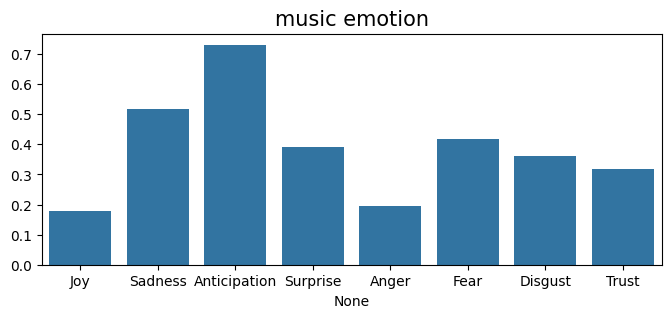

In [ ]:
# 特定の曲のデータだけを抽出
from matplotlib import pyplot as plt
import seaborn as sns
dfx = pd.read_csv('regression_bert+_1_6//lyric_com.csv')
dfx = dfx.rename(columns=dict(zip(dfx.columns, emotion_names)))
df_com = pd.read_csv('artist_combined.csv', encoding='shift_jis')
song_data = dfx[df_com['曲名'] == 'HANABI']
plt.figure(figsize=(8, 3))
sns.barplot(x=song_data.columns, y=song_data.values[0])
plt.title('music emotion', fontsize=15)

In [ ]:
import pandas as pd
%cd '/content/drive/MyDrive/成果物3/'
dfb = pd.read_csv('regression_bert+_1_6//lyric_com.csv')
dfc = pd.read_csv('artist_combined.csv', encoding='shift_jis')
dfb

/content/drive/MyDrive/成果物3


,Joy,Sadness,Anticipation,Surprise,Anger,Fear,Disgust,Trust
0,0.080925,0.287510,0.621739,0.307655,0.161083,0.519170,0.268200,0.330456
1,0.038796,0.214639,0.288993,0.302648,0.417803,0.031165,0.556503,0.188516
2,0.243551,0.386713,0.648567,0.235995,0.173143,0.254449,0.123006,0.486159
3,0.389480,0.393406,0.393494,0.322061,0.151189,0.331126,0.151316,0.508776
4,0.223618,0.233636,0.320819,0.357471,0.320038,0.283106,0.484844,0.130716
...,...,...,...,...,...,...,...,...
349,0.322314,0.118697,0.720586,0.692422,0.183234,0.348665,0.132184,0.494999
350,0.583853,0.324658,0.576895,0.321540,0.112317,0.293303,0.132359,0.693135
351,0.119448,0.717462,0.269920,0.155086,0.274536,0.382561,0.643667,0.135178
352,0.311389,0.458184,0.600043,0.315777,0.201007,0.378892,0.392175,0.215463


In [ ]:
dfc

,曲名,歌い出し,name,album,artist,length,popularity,key,mode,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,valence
0,Awake,Pandemic Plandemic 地球よ are you ready？ 消えてくmone...,Awake,Partition,Awich,144706,22,10,0,0.584,0.220000,0.489,0.000082,0.1780,-10.058,0.2220,175.298,3,0.418
1,Ashes,First I heisted But I called your mom back Cau...,Ashes,8,Awich,245194,20,4,0,0.396,0.211000,0.528,0.000000,0.6080,-9.781,0.2170,121.047,4,0.406
2,Arigato,I'll cry you a river 海へと渡るこの涙 Will heal my sou...,Arigato,孔雀,Awich,305099,20,0,0,0.695,0.028500,0.725,0.000108,0.3960,-6.670,0.0374,123.016,4,0.512
3,Wait For Me,嵐が吹き荒れる夜はもう慣れた 朝には必ず晴れる Please remember that 寝...,Wait For Me,THE UNION,Awich,252361,29,2,1,0.411,0.943000,0.245,0.000030,0.0921,-10.905,0.0887,200.747,4,0.253
4,WheU@,Straight from the Far East archipelago いつもやらかし...,WheU@,Queendom,Awich,156040,28,1,1,0.831,0.125000,0.818,0.003470,0.0748,-5.834,0.2130,93.499,4,0.905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,ROLLIN' ROLLING 〜一見は百聞に如かず,いいかい そこの御主人 耳をかっ穿って よく聞いてってくれ いいかい そこのお嬢さん 足を止...,ROLLIN' ROLLING 〜一見は百聞に如かず,REFLECTION｛Naked｝,Mr.Children,254429,23,5,0,0.526,0.010600,0.821,0.000013,0.3370,-5.011,0.0359,97.064,4,0.458
350,忘れ得ぬ人,どうしたら説明つくだろう？ 君に そして自分自身に まるで理想通りの美しさをすぐ目の前にして...,忘れ得ぬ人,REFLECTION｛Naked｝,Mr.Children,320733,29,2,1,0.516,0.465000,0.359,0.000000,0.0994,-6.846,0.0296,143.826,4,0.391
351,WALTZ,「光」「夢」「微笑み」 さようなら 「闇」「絶望」「悲しみ」 こんにちは 商品に適さぬと は...,WALTZ,REFLECTION｛Naked｝,Mr.Children,407253,24,4,0,0.359,0.000953,0.799,0.000046,0.0900,-5.425,0.0308,185.832,3,0.313
352,one two three,｢戦闘服よりはブレザーがよく似合う｣ 浴びせられた最終の嫌みが胸をえぐる 君の目からすれば ...,one two three,It's a wonderful world,Mr.Children,299160,32,7,1,0.519,0.008530,0.670,0.000000,0.1070,-6.423,0.0251,82.716,4,0.504


In [ ]:
dfd = dfc.copy()
#dfd = dfd.drop(columns=['曲名', '歌い出し', 'album', 'artist', 'popularity', ])
dfy = pd.concat([dfd, dfb], axis=1)
dfy

,曲名,歌い出し,name,album,artist,length,popularity,key,mode,danceability,...,time_signature,valence,Joy,Sadness,Anticipation,Surprise,Anger,Fear,Disgust,Trust
0,Awake,Pandemic Plandemic 地球よ are you ready？ 消えてくmone...,Awake,Partition,Awich,144706,22,10,0,0.584,...,3,0.418,0.080925,0.287510,0.621739,0.307655,0.161083,0.519170,0.268200,0.330456
1,Ashes,First I heisted But I called your mom back Cau...,Ashes,8,Awich,245194,20,4,0,0.396,...,4,0.406,0.038796,0.214639,0.288993,0.302648,0.417803,0.031165,0.556503,0.188516
2,Arigato,I'll cry you a river 海へと渡るこの涙 Will heal my sou...,Arigato,孔雀,Awich,305099,20,0,0,0.695,...,4,0.512,0.243551,0.386713,0.648567,0.235995,0.173143,0.254449,0.123006,0.486159
3,Wait For Me,嵐が吹き荒れる夜はもう慣れた 朝には必ず晴れる Please remember that 寝...,Wait For Me,THE UNION,Awich,252361,29,2,1,0.411,...,4,0.253,0.389480,0.393406,0.393494,0.322061,0.151189,0.331126,0.151316,0.508776
4,WheU@,Straight from the Far East archipelago いつもやらかし...,WheU@,Queendom,Awich,156040,28,1,1,0.831,...,4,0.905,0.223618,0.233636,0.320819,0.357471,0.320038,0.283106,0.484844,0.130716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,ROLLIN' ROLLING 〜一見は百聞に如かず,いいかい そこの御主人 耳をかっ穿って よく聞いてってくれ いいかい そこのお嬢さん 足を止...,ROLLIN' ROLLING 〜一見は百聞に如かず,REFLECTION｛Naked｝,Mr.Children,254429,23,5,0,0.526,...,4,0.458,0.322314,0.118697,0.720586,0.692422,0.183234,0.348665,0.132184,0.494999
350,忘れ得ぬ人,どうしたら説明つくだろう？ 君に そして自分自身に まるで理想通りの美しさをすぐ目の前にして...,忘れ得ぬ人,REFLECTION｛Naked｝,Mr.Children,320733,29,2,1,0.516,...,4,0.391,0.583853,0.324658,0.576895,0.321540,0.112317,0.293303,0.132359,0.693135
351,WALTZ,「光」「夢」「微笑み」 さようなら 「闇」「絶望」「悲しみ」 こんにちは 商品に適さぬと は...,WALTZ,REFLECTION｛Naked｝,Mr.Children,407253,24,4,0,0.359,...,3,0.313,0.119448,0.717462,0.269920,0.155086,0.274536,0.382561,0.643667,0.135178
352,one two three,｢戦闘服よりはブレザーがよく似合う｣ 浴びせられた最終の嫌みが胸をえぐる 君の目からすれば ...,one two three,It's a wonderful world,Mr.Children,299160,32,7,1,0.519,...,4,0.504,0.311389,0.458184,0.600043,0.315777,0.201007,0.378892,0.392175,0.215463


In [ ]:
dfy.to_csv('regression_bert+_1_6//comdata.csv', index=False, encoding='utf-8-sig')